# Getting started with JAX

[JAX](http://jax.readthedocs.io) is a Python package for accelerator-oriented array computation and program transformation, and is the engine behind cutting-edge AI research and production models at Google and beyond.

## Who is this tutorial for?

This tutorial is for those who want to get started using JAX to build and train neural network models. It assumes some familiarity with numerical computing in Python with [NumPy](http://numpy.org), and assumes some conceptual familiarity with defining, training, and evaluating machine learning models.

## What does this tutorial cover?

JAX itself focuses on array-based computation, and is at the core of a growing ecosystem of domain-specific tools. This tutorial introduces part of that ecosystem that is useful for defininig and training AI models, including:

- [flax](http://flax.readthedocs.io): a tool designed for defining and building
  scalable neural networks using JAX.
- [optax](http://optax.readthedocs.io): a tool designed for high-performance
  optimization of functions in JAX, including the loss functions used in neural network training.

Once you've worked through this content, you may wish to visit http://jax.readthedocs.io/ for a deeper dive into the JAX library itself.

## Example: a simple neural network with flax

We'll start with a very quick example of what it looks like to use JAX with the [flax](https://flax.readthedocs.io) framework to define and train a very simple neural network on a hand-written digits dataset.

### Loading the data

JAX can work with a variety of data loaders, but for simplicity here we can use the well-known [scikit-learn `digits`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

print(f"{digits.data.shape=}")
print(f"{digits.target.shape=}")

digits.data.shape=(1797, 64)
digits.target.shape=(1797,)


This dataset consists of 8x8 pixelized images of hand-written digits along with labels, and we can visualize a handful of them this way:

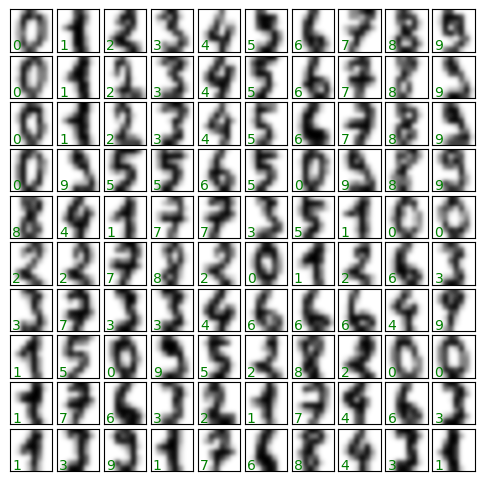

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='gaussian')
    ax.text(0.05, 0.05, str(digits.target[i]), transform=ax.transAxes, color='green')

Let's split these into a training and testing set, and convert these splits into JAX arrays which will be ready to feed into our model:

In [3]:
from sklearn.model_selection import train_test_split
splits = train_test_split(digits.images, digits.target, random_state=0)

In [4]:
import jax.numpy as jnp
images_train, images_test, label_train, label_test = map(jnp.asarray, splits)
print(f"{images_train.shape=} {label_train.shape=}")
print(f"{images_test.shape=}  {label_test.shape=}")

images_train.shape=(1347, 8, 8) label_train.shape=(1347,)
images_test.shape=(450, 8, 8)  label_test.shape=(450,)


### Defining the flax model

We can now use the [Flax](http://flax.readthedocs.io) package to create a simple [Feedforward](https://en.wikipedia.org/wiki/Feedforward_neural_network) neural network withone hidden layer, and use a *scaled exponential linear unit* (SELU) activation function:

In [5]:
from flax import nnx

N_FEATURES = 64  # Number of pixels.
N_INTERMEDIATE = 100  # Hidden layer size
N_TARGETS = 10  # Number of categories.

class SimpleNN(nnx.Module):

  def __init__(self, *, rngs: nnx.Rngs):
    self.layer1 = nnx.Linear(N_FEATURES, N_INTERMEDIATE, rngs=rngs)
    self.layer2 = nnx.Linear(N_INTERMEDIATE, N_INTERMEDIATE, rngs=rngs)
    self.layer3 = nnx.Linear(N_INTERMEDIATE, N_TARGETS, rngs=rngs)

  def __call__(self, x):
    x = x.reshape(-1, 64)  # flatten 8x8 images
    x = nnx.selu(self.layer1(x))
    x = nnx.selu(self.layer2(x))
    x = self.layer3(x)
    return x

model = SimpleNN(rngs=nnx.Rngs(0))

### Training the model

With this model defined, we can now use the [optax](http://optax.readthedocs.io) package to train it.
First we define a loss function using [`optax.softmax_cross_entropy_with_integer_labels`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.losses.softmax_cross_entropy_with_integer_labels), and then a training step based on this optimizer:

In [6]:
import jax
import optax

optimizer = nnx.Optimizer(model, optax.sgd(learning_rate=0.05))

def loss_fun(
    model: nnx.Module,
    data: jax.Array,
    labels: jax.Array):
  logits = model(data)
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=labels
  ).mean()
  return loss, logits

@nnx.jit  # JIT-compile the function
def train_step(
    model: nnx.Module,
    optimizer: nnx.Optimizer,
    data: jax.Array,
    labels: jax.Array):
  loss_gradient = nnx.value_and_grad(loss_fun, has_aux=True)  # gradient transform!
  (loss, logits), grads = loss_gradient(model, data, labels)
  optimizer.update(grads)  # inplace update

Notice here the use of `nnx.jit` and `nnx.grad`, which are transformations built on `jax.jit` and `jax.grad`: `jit` is a Just In Time compilation transformation, and will cause the function to be passed to the XLA compiler for fast repeated execution. `grad` is a gradient transformation, and uses JAX's automatic differentiation for fast optimization of large networks.
We'll return to these transformations further below.

Now we define a training loop to repeatedly perform this train step over our training data, periodically printing the loss against the test set to monitor convergence:

In [7]:
for i in range(301):  # 300 training epochs
  train_step(model, optimizer, images_train, label_train)
  if i % 50 == 0:  # Print metrics.
    loss, _ = loss_fun(model, images_test, label_test)
    print(f"epoch {i}: loss={loss:.2f}")

epoch 0: loss=5.68
epoch 50: loss=0.16
epoch 100: loss=0.12
epoch 150: loss=0.11
epoch 200: loss=0.10
epoch 250: loss=0.10
epoch 300: loss=0.10


After 300 training epochs, our model appears to have converged to a target loss of `0.10`; lets look at what this implies for the accuracy of the labels for each image:

In [8]:
label_pred = model(images_test).argmax(axis=1)
num_matches = jnp.count_nonzero(label_pred == label_test)
num_total = len(label_test)
accuracy = num_matches / num_total
print(f"{num_matches} labels match out of {num_total}:"
      f" accuracy = {num_matches/num_total:%}")

438 labels match out of 450: accuracy = 97.333336%


Our simple feed-forward network has achieved approximately 98% accuracy on the test set.
We can do a similar visualization as above to see some examples that the model predicted correctly (green) and incorrectly (red):

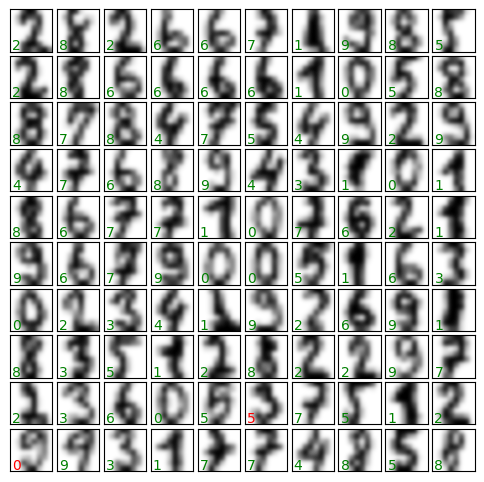

In [9]:
fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_test[i], cmap='binary', interpolation='gaussian')
    color = 'green' if label_pred[i] == label_test[i] else 'red'
    ax.text(0.05, 0.05, str(label_pred[i]), transform=ax.transAxes, color=color)

We've just scraped the surface with Flax here; the package includes a number of useful APIs for tracking metrics during training; you can see these in action in the [MNIST tutorial](https://flax.readthedocs.io/en/latest/nnx/mnist_tutorial.html) on the Flax website.

## JAX key features

The Flax neural network API demonstrated above takes advantage of a number of key JAX features, designed into the library from the ground up. In particular:

- **JAX provides a familiar NumPy-like API for array computing**.
  This means that when processing data and outputs, we can reach for APIs like [`jax.numpy.count_nonzero`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.count_nonzero.html), which mirror the familiar APIs of the NumPy package; in this case [`numpy.count_nonzero`](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html).

- **JAX provides just-in-time (JIT) compilation.**
  This means that you can implement your code easily in Python, but count on fast compiled execution on CPU, GPU, and TPU backends via the [XLA](https://openxla.org/xla) compiler by wrapping your code with a simple [`jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html) transformation.

- **JAX provides automatic differentiation (autodiff).**
  This means that when fitting models, `optax` and `flax` can compute closed-form gradient functions for fast optimization of models, using the [`grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) transformation.

- **JAX provides automatic vectorization.**
  We didn't use it directly above, but under the hood flax takes advantage of JAX's vectorized map ([`vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)) to automatically convert loss and gradient functions to efficient batch-aware functions that are just as fast as hand-written versions. This makes JAX implementations simpler and less error-prone.

We'll briefly show further examples of these in the following sections.

### JAX NumPy interface

The foundational array computing package in Python is NumPy, and JAX provides a matching API via the `jax.numpy` subpackage.
Additionally, JAX arrays behave much like NumPy arrays in their attributes, and in terms of [indexing](https://numpy.org/doc/stable/user/basics.indexing.html) and [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) semantics.

Above we used the built-in `flax.nnx.selu` implementation, but we could instead implement our own version with JAX's NumPy API:

In [10]:
import jax.numpy as jnp

def selu(x, alpha=1.67, lam=1.05):
  return lam * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
print(selu(x))

[0.        1.05      2.1       3.1499999 4.2      ]


Despite the broad similarities, be aware that JAX does have some well-motivated differences from NumPy that you can read about in [JAX – the sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html).

### Just-in-time compilation

JAX is built on the XLA compiler, and allows sequences of operations to be Just-in-time (JIT) compiled using the `jax.jit` transformation.
In the example above, we used the similar `nnx.jit` API, which has some special handling for Flax objects, for speed in our neural network training.

Returning to our `selu` function, we can create a JIT-compiled version this way:

In [11]:
import jax
selu_jit = jax.jit(selu)

`selu_jit` is now a compiled version of the original function, which returns the same result to typical floating-point precision:

In [12]:
x = jnp.arange(1E6)
jnp.allclose(selu(x), selu_jit(x))  # results match

Array(True, dtype=bool)

We can use IPython's `%timeit` magic to see the speedup (note the use of `.block_until_ready()`, which we use to account for JAX's [asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html)):

In [13]:
%timeit selu(x).block_until_ready()

8.32 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit selu_jit(x).block_until_ready()

1.38 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For this computation, running on CPU, JIT compilation gives an order of magnitude speedup.
JAX's documentation has more discussion of JIT compilation at [Just-in-time compilation](https://jax.readthedocs.io/en/latest/jit-compilation.html).

### Automatic differentiation

For efficient optimization of neural network models, fast gradient computations are essential. JAX enables this via its automatic differentiation transformations like [`jax.grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html), which computes a closed-form gradient of a JAX function. In the example above, we used the similar `nnx.grad` function, which has special handling for `flax.nnx` objects.

Here's how to compute the gradient of a function with `jax.grad`:

In [15]:
x = jnp.float32(-1.0)
jax.grad(selu)(x)

Array(0.6450766, dtype=float32)

We can briefly check with a finite-difference approximation that this is giving the expected value:

In [16]:
eps = 1E-3
(selu(x + eps) - selu(x)) / eps

Array(0.64539903, dtype=float32)

Importantly, the automatic differentiation approach is both more accurate and more efficient than computing numerical gradients. JAX's documentation has more discussion of autodiff at [Automatic differentiation](https://jax.readthedocs.io/en/latest/automatic-differentiation.html).

### Automatic vectorization

In our training loop above, we defined our loss function in terms of a single input data vector of shape `n_features`, but trained our model by passing batches of data (of shape `[n_samples, n_features]`). Rather than requiring a naive and slow loop over batches in Flax & Optax internals, they instead use JAX's automatic vectorization via the `jax.vmap` transformation to construct a batched version of the kernel automatically.

Consider a simple loss function that looks like this:

In [17]:
def loss(x: jax.Array, x0: jax.Array):
  return jnp.sum((x - x0) ** 2)

We can evaluate it on a single data vector this way:

In [18]:
x = jnp.arange(3.)
x0 = jnp.ones(3)
loss(x, x0)

Array(2., dtype=float32)

But if we attempt to evaluate it on a batch of vectors, it does not correctly return a batch of 4 losses:

In [19]:
batched_x = jnp.arange(12).reshape(4, 3)  # batch of 4 vectors
loss(batched_x, x0)  # wrong!

Array(386., dtype=float32)

The problem is that our loss function is not batch-aware. Without automatic vectorization, there are two ways you can address this:

1. Re-write your loss function by hand to operate on batched data; however, as functions become more complicated, this becomes difficult and error-prone.
2. Naively loop over unbatched calls to your original function; however, this is easy to code, but can be slow because it doesn't take advantage of vectorized compute.

The `jax.vmap` transformation offers a third way: it automatically transforms your original function into a batch-aware version, so you get the speed of option 1 with the ease of option 2:

In [20]:
loss_batched = jax.vmap(loss, in_axes=(0, None))  # batch x over axis 0, do not batch x0
loss_batched(batched_x, x0)

Array([  2.,  29., 110., 245.], dtype=float32)

In our neural network example above, both `flax` and `optax` make use of JAX's `vmap` to allow for efficient batched computations over our unbatched loss function.

JAX's documentation has more discussion of autodiff at [Automatic vectorization](https://jax.readthedocs.io/en/latest/automatic-vectorization.html).